In [16]:
# -*- coding: utf-8 -*-
"""
Created on Sun Feb 28 16:58:28 2021

@author: hamdi
"""

import numpy as np
from scipy.spatial import distance
from sklearn.datasets import make_circles
from scipy.optimize import least_squares
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import cdist
import pandas as pd
import random
from sklearn.datasets import make_classification,make_regression
from sklearn.ensemble import RandomForestRegressor
from skmlm import MLM,MLMC,NN_MLM
from sklearn.datasets import load_iris
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import RDF_MLM as mlm
sns.set_style("darkgrid")

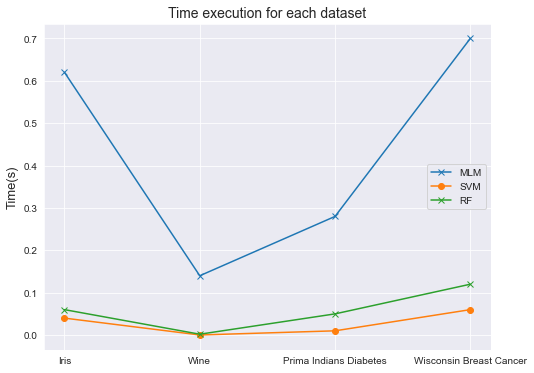

In [30]:
plt.figure(figsize=(8,6))
plt.title("Time execution for each dataset",fontsize=14)
plt.xticks(np.arange(5),["Iris","Wine","Prima Indians Diabetes","Wisconsin Breast Cancer"])
plt.ylabel("Time(s)",fontsize=13)
plt.plot([0.62,0.14,0.28,0.7],"-x",label="MLM")
plt.plot([0.04,0.0002,0.01,0.06],"-o",label="SVM")
plt.plot([0.06,0.002,0.05,0.12],"-x",label="RF")
plt.legend()
plt.show()

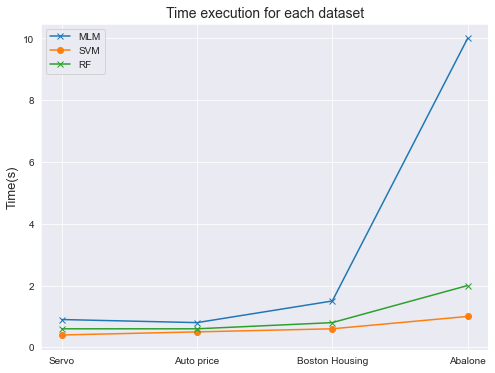

In [31]:
plt.figure(figsize=(8,6))
plt.title("Time execution for each dataset",fontsize=14)
plt.xticks(np.arange(5),["Servo","Auto price","Boston Housing","Abalone"])
plt.ylabel("Time(s)",fontsize=13)
plt.plot([0.9,0.8,1.5,10],"-x",label="MLM")
plt.plot([0.4,0.5,0.6,1],"-o",label="SVM")
plt.plot([0.6,0.6,0.8,2],"-x",label="RF")
plt.legend()
plt.show()

In [9]:
# charger les données 
domain = pd.read_csv("Servo/servo.domain",delimiter=":", names=["column","type" ])
servo = pd.read_csv("Servo/servo.data",names=domain.column.to_list())

domain = pd.read_csv("Housing/housing.domain",delimiter=":", names=["column","type" ])
housing = pd.read_csv("Housing/housing.data",names=domain.column.to_list())

domain = pd.read_csv("Auto-Price/price.domain",delimiter=":", names=["column","type","unknow"])
price = pd.read_csv("Auto-Price/price.data",names=domain.column.to_list())

domain = pd.read_csv("Abalone/abalone.domain",delimiter=":", names=["column","type" ])# Pour charger les noms des dolonnes
abalone = pd.read_csv("Abalone/abalone.data",names=domain.column.to_list()) # charher la dataset, 


def split_and_norm(X,y,name,test_size=1/3):
    if name == "c":
        classes = [list() for i in range(len(np.unique(y)))]# séparer les données selon la classe
        for i in range(len(X)):
            classes[int(y[i])].append(np.append(X[i],[y[i]],axis=0))
        classes = [np.array(e) for e in classes]
        train,test = train_test_split(classes[0],test_size=test_size,random_state=42)
        for k in range(1,len(classes)):
            train_k,test_k = train_test_split(classes[k],test_size=test_size,random_state=42)
            train = np.append(train,train_k,axis = 0)
            test = np.append(test,test_k,axis = 0)
        size = train.shape[1]
        x_train,x_test = train[:,:size-1],test[:,:size-1]
        y_train,y_test = train[:,size-1],test[:,size-1]
    elif name == "r":
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state=42)
    # centrer réduire
    mx = x_train.mean(axis=0)
    ecart1 = x_train.std()
    return (x_train-mx)/ecart1,(x_test-mx)/ecart1,y_train,y_test

def preprocessing(dataset):
    # séparer les colonnes en deux types catégorielles et numériques
    cat_col=[col for col in dataset.columns if dataset[col].dtype=='object']
    num_col=[col for col in dataset.columns if dataset[col].dtype=='int64' or dataset[col].dtype=='float64']
    # garder uniquement les colonnes catégorielles et supprimer les valeurs manquantes 
    dataset = dataset[num_col].dropna(axis=0)
    # 10 pérmutation aléatoire pour mélanger les données 

    for i in range(10):
        dataset=shuffle(dataset,random_state=0)
    data = dataset.to_numpy()
    size = data.shape[1]
    X = data[:,:size-1]
    y = data[:,size-1]
    return X,y


FileNotFoundError: [Errno 2] File Servo/servo.domain does not exist: 'Servo/servo.domain'

In [10]:
class PM_MLM():
    def __init__(self,rp_number=None,random_state=42):
        self.rp_number = rp_number
        if self.rp_number == None: self.rp_number = 0.1
        self.random_state = random_state
        
    def selectRP(self,X,y):
        n = len(X)
        if self.rp_number <= 1:
            self.rp_number = int(self.rp_number * n)
        
        #y = y.reshape((n,1))
        r = np.random.RandomState(self.random_state)
        id_rp = r.choice(range(n),self.rp_number,replace=False)
        self.rp_x = X[id_rp]
        self.rp_y = y[id_rp]
        return self.rp_x,self.rp_y

    def pinv_(self,D_x):
        try:
            return np.linalg.inv(D_x.T @ D_x) @ D_x.T
        except Exception as e:
            return np.linalg.pinv(D_x)
    
    def fit(self,D_x,D_y):
        self.B = self.pinv_(D_x) @ D_y 

    def cost(self,y,x,d_x):
        #print(y)
        y = np.array(y).reshape((1,len(y)))
        print(y.shape,self.rp_y.shape)
        d_y  = cdist(y,self.rp_y)# elle seras modifier selon la méthode de calcul de la distance 
        return ((d_y**2 - (d_x@self.B)**2)**2)[0]

    def optimse(self,x,d_x):
        J = lambda y: self.cost(y,x,d_x)
        out = least_squares(J,x0 =self.rp_y.mean(axis=0),method='lm')
        return out.x[0]

    def predict(self,X,D_x):
        return np.array([self.optimse(x,d_x) for x,d_x in zip(X,D_x)])
    



In [11]:
# -*- coding: utf-8 -*-
"""

@author: hamdi
"""

import numpy as np
from scipy.optimize import least_squares
from scipy.spatial.distance import cdist
import random
from sklearn.ensemble import RandomForestRegressor

from abc import abstractmethod
from sklearn.base import BaseEstimator, RegressorMixin,ClassifierMixin
from sklearn.exceptions import NotFittedError
from sklearn.utils.validation import check_is_fitted, check_array
from sklearn.utils.estimator_checks import check_estimator
from sklearn.base import is_classifier

from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.ensemble._forest import BaseForest
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV



__all__ = ["RFDClassifier",
           "RFSVMClassifier"]

def check_dissimilarity_matrix(diss_matrix, X):
    """
    Checks if the given dissimilarity matrix is valid:
    - the dissimilarity matrix must be a NxN matrix, N begin the number of instances in X (number of rows)
    - the diagonal elements of the dissimilarity matrix must be equal to 0

    :param diss_matrix: the dissimilarity matrix
    :param X: the dataset from which the dissimilarity matrix is supposed to be computed
    """
    M, N = diss_matrix.shape
    n_instances, n_features = X.shape

    if M != N:
        raise ValueError("The dissimilarity matrix must be squared")

    if M != n_instances:
        raise ValueError("The dissimilarity matrix must be a NxN matrix, N being the number of instances"
                         "in the given training set X")

    diag = np.sum(np.diagonal(diss_matrix))
    if diag != 0:
        raise ValueError("The diagonal elements of the dissimilarity matrix must all be equal to 0")

################## Base Random Forest Regrossor #########################################################

class BaseRFDRegressor(BaseEstimator, RegressorMixin):
    """
    Base class for Random Forest Dissimilarity (RFD) based learning
    Warning: This class should not be used directly. Use derived classes
    instead.
    """

    @abstractmethod
    def __init__(self,
                 estimator: BaseEstimator,
                 forest: BaseForest = None):
        self.forest = forest
        self.estimator = estimator
        self.dissimilarity_matrix = None
        self.leaves_ = None

        if self.forest is None:
            self.forest = RandomForestRegressor(n_estimators=100)



    def fit(self, X, y):
        """
        :param X: an NxD input matrix, N being the number of training instances and D being the number of features
        :param y: an N-sized output vector that contains the true labels of the training instances
        :param dissim_matrix: an already built dissimilarity matrix or None
        :return: self
        """

        # step 1 - fit the forest on the training set
        try:
            check_is_fitted(self.forest, 'estimators_')
        except NotFittedError:
            self.forest.fit(X, y)

        # step 2 - compute the dissimilarity matrix from this forest
        self.dissimilarity_matrix = self._get_dissimilarity_matrix(X, y)
        check_dissimilarity_matrix(self.dissimilarity_matrix, X)

        # step 3 - fit the second estimator on the dissimilarity matrix
        self._fit_estimator(self.dissimilarity_matrix, y)

        return self

    @abstractmethod
    def _get_dissimilarity_matrix(self, X, y):
        """
        abstract method
        Compute the dissimilarity matrix from a given training set.

        This function is not supposed to be used alone. It is called in the fit function and
        suppose the self.forest to have been fitted on the same training set.
        The only reason to define a separate function here is to allow for overriding

        :param X: The training instances
        :param y: The true labels
        :return: The dissimilarity matrix computed from self.forest
        """
        pass

    def _fit_estimator(self, X_diss, y):
        """
        :param X_diss: a dissimilarity matrix, i.e. the dissimilarity representation of a training set
        :param y: the true labels
        :return: the fitted estimator
        """
        check_estimator(self.estimator)
        return self.estimator.fit(X_diss, y)

    def predict(self, X):
        """
        """
        check_is_fitted(self.estimator)
        X = check_array(X)
        X_diss = self.get_dissimilarity_representation(X)
        return self.estimator.predict(X_diss)

    @abstractmethod
    def get_dissimilarity_representation(self, X):
        """
        abstract method
        Compute the dissimilarity representation of X

        :param X:
        :return:
        """
        pass

################## Random Forest Regressor #############################################

class RFDRegressor(BaseRFDRegressor):
    """
    Random Forest Dissimilarity (RFD) based learning for Classification tasks
    """

    def __init__(self,
                 estimator: BaseEstimator = RandomForestRegressor(n_estimators=100),
                 forest: BaseForest = None):
        super().__init__(estimator, forest)

    def _get_dissimilarity_matrix(self, X, y):
        """
        Compute the dissimilarity matrix from a given training set.

        This function is not supposed to be used alone. It is called in the fit function and
        suppose the self.forest to have been fitted on the same training set.
        The only reason to define a separate function here is to allow for overriding

        :param X: The training instances
        :param y: The true labels
        :return: The dissimilarity matrix computed from self.forest
        """
        try:
            check_is_fitted(self.forest, 'estimators_')
        except NotFittedError:
            raise ValueError("This function must not be called alone. It is called by the fit function"
                             "to ensure that self.forest is fitted first on the same training set")

        # 1 - store all the leaves for all x in X
        # self.leaves_ is a NxL matrix, with N the number of instances and L the number of trees in the forest
        self.leaves_ = self.forest.apply(X)

        # 2 - compute the similarity matrix for the first tree
        # a is a N-sized vector with the leaves' number of the first tree for all x in X
        # sim is a NxN matrix with 0s and 1s
        a = self.leaves_[:, 0]
        sim = 1 * np.equal.outer(a, a)

        # 3 - for each tree in the forest update the similarity matrix by cumulating
        # the tree similarity matrices in sim
        for i in range(1, self.forest.n_estimators):
            a = self.leaves_[:, i]
            sim += 1 * np.equal.outer(a, a)

        # 4 - average and 1-sim to obtain the final dissimilarity matrix
        sim = sim / self.forest.n_estimators
        self.dissimilarity_matrix = 1 - sim
        return self.dissimilarity_matrix

    def get_dissimilarity_representation(self, X):
        """
        Compute the dissimilarity representation of X

        :param X: an instance (D-sized vector) or a dataset (NxD matrix)
        :return:
        """
        check_is_fitted(self.forest, 'estimators_')
        X_sim = np.empty((X.shape[0], 0))
        X_leaves = self.forest.apply(X)
        for xi in self.leaves_:
            matches = X_leaves == np.reshape(xi, (1, xi.shape[0]))
            sim = np.sum(matches, axis=1) / self.forest.n_estimators
            X_sim = np.append(X_sim, np.reshape(sim, (X.shape[0], 1)), axis=1)
        return 1 - X_sim
    
################################# base  Random Forest Classifier ###################################
class BaseRFDClassifier(BaseEstimator, ClassifierMixin):
    """
    Base class for Random Forest Dissimilarity (RFD) based learning
    Warning: This class should not be used directly. Use derived classes
    instead.
    """

    @abstractmethod
    def __init__(self,
                 estimator: BaseEstimator,
                 forest: BaseForest = None):
        self.forest = forest
        self.estimator = estimator
        self.dissimilarity_matrix = None
        self.leaves_ = None

        if self.forest is None:
            self.forest = RandomForestClassifier(n_estimators=100)

        if not is_classifier(self.estimator):
            raise TypeError("The estimator must be a classifier")

    def fit(self, X, y):
        """
        :param X: an NxD input matrix, N being the number of training instances and D being the number of features
        :param y: an N-sized output vector that contains the true labels of the training instances
        :param dissim_matrix: an already built dissimilarity matrix or None
        :return: self
        """

        # step 1 - fit the forest on the training set
        try:
            check_is_fitted(self.forest, 'estimators_')
        except NotFittedError:
            self.forest.fit(X, y)

        # step 2 - compute the dissimilarity matrix from this forest
        self.dissimilarity_matrix = self._get_dissimilarity_matrix(X, y)
        check_dissimilarity_matrix(self.dissimilarity_matrix, X)

        # step 3 - fit the second estimator on the dissimilarity matrix
        self._fit_estimator(self.dissimilarity_matrix, y)

        return self

    @abstractmethod
    def _get_dissimilarity_matrix(self, X, y):
        """
        abstract method
        Compute the dissimilarity matrix from a given training set.

        This function is not supposed to be used alone. It is called in the fit function and
        suppose the self.forest to have been fitted on the same training set.
        The only reason to define a separate function here is to allow for overriding

        :param X: The training instances
        :param y: The true labels
        :return: The dissimilarity matrix computed from self.forest
        """
        pass

    def _fit_estimator(self, X_diss, y):
        """
        :param X_diss: a dissimilarity matrix, i.e. the dissimilarity representation of a training set
        :param y: the true labels
        :return: the fitted estimator
        """
        check_estimator(self.estimator)
        return self.estimator.fit(X_diss, y)

    def predict(self, X):
        """
        """
        check_is_fitted(self.estimator)
        X = check_array(X)
        X_diss = self.get_dissimilarity_representation(X)
        return self.estimator.predict(X_diss)

    @abstractmethod
    def get_dissimilarity_representation(self, X):
        """
        abstract method
        Compute the dissimilarity representation of X

        :param X:
        :return:
        """
        pass

####################### Random Forest Classifier #########################################
class RFDClassifier(BaseRFDClassifier):
    """
    Random Forest Dissimilarity (RFD) based learning for Classification tasks
    """

    def __init__(self,
                 estimator: BaseEstimator = RandomForestClassifier(n_estimators=100),
                 forest: BaseForest = None):
        super().__init__(estimator, forest)

    def _get_dissimilarity_matrix(self, X, y):
        """
        Compute the dissimilarity matrix from a given training set.

        This function is not supposed to be used alone. It is called in the fit function and
        suppose the self.forest to have been fitted on the same training set.
        The only reason to define a separate function here is to allow for overriding

        :param X: The training instances
        :param y: The true labels
        :return: The dissimilarity matrix computed from self.forest
        """
        try:
            check_is_fitted(self.forest, 'estimators_')
        except NotFittedError:
            raise ValueError("This function must not be called alone. It is called by the fit function"
                             "to ensure that self.forest is fitted first on the same training set")

        # 1 - store all the leaves for all x in X
        # self.leaves_ is a NxL matrix, with N the number of instances and L the number of trees in the forest
        self.leaves_ = self.forest.apply(X)

        # 2 - compute the similarity matrix for the first tree
        # a is a N-sized vector with the leaves' number of the first tree for all x in X
        # sim is a NxN matrix with 0s and 1s
        a = self.leaves_[:, 0]
        sim = 1 * np.equal.outer(a, a)

        # 3 - for each tree in the forest update the similarity matrix by cumulating
        # the tree similarity matrices in sim
        for i in range(1, self.forest.n_estimators):
            a = self.leaves_[:, i]
            sim += 1 * np.equal.outer(a, a)

        # 4 - average and 1-sim to obtain the final dissimilarity matrix
        sim = sim / self.forest.n_estimators
        self.dissimilarity_matrix = 1 - sim
        return self.dissimilarity_matrix

    def get_dissimilarity_representation(self, X):
        """
        Compute the dissimilarity representation of X

        :param X: an instance (D-sized vector) or a dataset (NxD matrix)
        :return:
        """
        check_is_fitted(self.forest, 'estimators_')
        X_sim = np.empty((X.shape[0], 0))
        X_leaves = self.forest.apply(X)
        for xi in self.leaves_:
            matches = X_leaves == np.reshape(xi, (1, xi.shape[0]))
            sim = np.sum(matches, axis=1) / self.forest.n_estimators
            X_sim = np.append(X_sim, np.reshape(sim, (X.shape[0], 1)), axis=1)
        return 1 - X_sim

######################### Minimal Learning Machine Regressor with Random Forest #########################
class RFDMLM_Regressor():
    def __init__(self,n_estimators=100,dist='euclidean'):
        self.n_estimators = n_estimators
        self.dist=dist
        self.RF = RFDRegressor(self.n_estimators) # initialize the random forest regressor 
        
    def pinv_(self,D_x): 
        try:
            return np.linalg.inv(D_x.T @ D_x) @ D_x.T# if the matrice is inversible
        except Exception as e:
            return np.linalg.pinv(D_x)# compute the pseudo inverse 
    
    def fit(self,X,y):
        self.x_train = X
        self.y_train = y.reshape((len(y),1))# reshape to compute output matrix distances
        self.RF.fit(self.x_train,y) # fit the random forest 
        self.train_dissim = self.RF.get_dissimilarity_representation(self.x_train)# get RF dissimilarity matrix 
        self.D_y = cdist(self.y_train,self.y_train,self.dist) # compute euclidean distances for output matrix
        self.B = self.pinv_(self.train_dissim) @ self.D_y# fit matrix of coefficients 
        
    def cost(self,y,x,d_x):
        y = np.array(y).reshape((1,len(y)))
        d_y  = cdist(y,self.y_train,self.dist)# compute the vector of dictences for y
        return ((d_y**2 - (d_x@self.B)**2)**2)[0] 

    def optimse(self,x,d_x):
        J = lambda y: self.cost(y,x,d_x)# the fonction to minimize 
        out = least_squares(J,x0 =self.y_train.mean(axis=0),method='lm') #minimization of the cost function
        return out.x[0]

    def predict(self,X):
        self.test_dissim = self.RF.get_dissimilarity_representation(X)# get RF dissimlarité for X
        return np.array([self.optimse(x,d_x) for (x,d_x) in zip(X,self.test_dissim)])
    

####################### Minimal Learning Machine Classifier with Random Forest Regressor ###########################

def one_hot(y):
    # transform vector of classes with one hot encoding 
    y = [int(i) for i in y.tolist()]
    l = len(y)
    c = len(np.unique(y))
    y_oh = np.zeros((l, c))
    y_oh[np.arange(l), y] = 1
    return y_oh

class RFDMLM_Classifier():
    def __init__(self,n_estimators=100,dist='euclidean'):
        self.n_estimators=estimators
        self.dist=dist
        self.RF = RFDClassifier(self.n_estimators)
        
    def pinv_(self,D_x):
        try:
            return np.linalg.inv(D_x.T @ D_x) @ D_x.T
        except Exception as e:
            return np.linalg.pinv(D_x)
    
    def fit(self,X,y):
        self.y_train = one_hot(y)
        self.x_train = X
        self.RF.fit(self.x_train,y)
        self.train_dissim = self.RF.get_dissimilarity_representation(self.x_train)
        self.D_y = cdist(self.y_train,self.y_train,self.dist) 
        self.B = self.pinv_(self.train_dissim) @ self.D_y
        

    def predict(self, X, y=None):
        self.test_dissim = self.RF.get_dissimilarity_representation(X)
        # compute matrix of distances from input RPs
        # estimate matrix of distances from output RPs
        D_y_hat = self.test_dissim @ self.B
        return self.y_train[D_y_hat.argmin(axis=1),:].argmax(axis=1)
    
    def score(self,X,y):
        pred = self.predict(X)
        assert pred.shape == y.shape
        s = 0
        size = len(y)
        for i in range(size):
            if pred[i] == y[i]:
                s+=1
        return s/size

In [13]:
clf = RFDMLM_Regressor(n_estimators=150).fit(X,y)

TypeError: Cannot clone object '150' (type <class 'int'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.